Install Dependencies

In [1]:
!pip install rocketlogger
!pip install pandas
!pip install matplotlib

Import dependencies and load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from numpy import linalg as LA
from rocketlogger.data import RocketLoggerData

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# # Configuration
# Export figure settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['ps.useafm'] = True

# constants
LPM_CURRENT_THRESHOLD = 150e-6 # ampere
TRIM_START = 1.0 # seconds
TRIM_END = 1.0 # seconds
    
# input folder
input_folder = os.path.join('./')

# input files -- update path 
measurement_file = '/content/drive/MyDrive/Colab Notebooks/2021-CNDS-Private-main/assignment1/sample_data/button_press.rld'

# Load data
data = RocketLoggerData(os.path.join(input_folder, measurement_file))
data = data.merge_channels(True)
data_sample_rate = int(data._header['sample_rate'])
data_comment = data.get_comment()

In [5]:
# RAW DATA
I_app = data.get_data('I1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
V_app = data.get_data('V1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]

print("Average supply voltage:  {:1.2f} V ".format(np.mean(V_app)))

Average supply voltage:  2.99 V 


Extract application states

In [6]:
# TIME
t_app = data.get_time()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
t_app = t_app - t_app[0]
dt_app = np.hstack([np.diff(t_app), 0])

# POWER 
P_app = 1 * V_app * I_app
# extract active periods when a button was pressed
app_active_window = (I_app) > LPM_CURRENT_THRESHOLD

# Determine the start and end of button presses based on the current threshold
# app refers to transmitting IR packets when a button is being pressed, which is the energy-intensive task.
app_start = np.diff(np.hstack([[0], app_active_window])) > 0
app_start_index = np.nonzero(app_start)[0]
num_start = len(app_start_index)
# extract the end of button press
app_end = np.diff(np.hstack([[0], app_active_window])) < 0
app_end_index = np.nonzero(app_end)[0]
num_end = len(app_end_index)

print('Num. button press starts recognized: ', num_start)
print('Num. button press ends recognized: ', num_end)

Num. button press starts recognized:  5
Num. button press ends recognized:  5


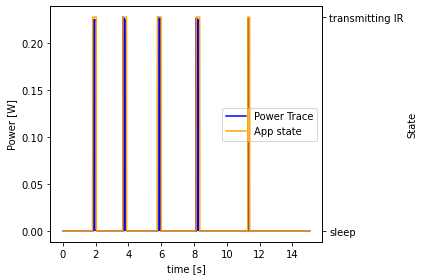

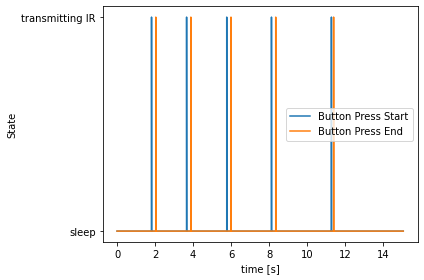

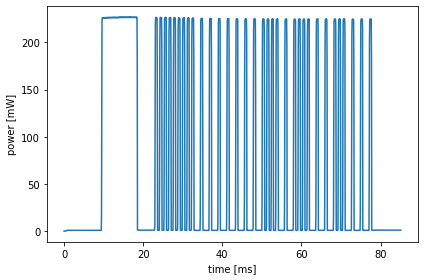

In [7]:
# plot the power trace and the calculated app state
fig, ax1 = plt.subplots()
lns1 = ax1.plot(t_app,P_app, label='Power Trace', color="blue")
plt.xlabel('time [s]')
plt.ylabel('Power [W]')
# second y axis
ax2 = ax1.twinx()
lns2 = ax2.plot(t_app,app_active_window, label='App state', color="orange")
ax2.set_ylabel('State')
ax2.set_yticks([0, 1])
ax2.set_yticklabels( ["sleep", "transmitting IR"])
# add legends for both lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
plt.tight_layout()
plt.savefig("power_overview.png", bbox_inches="tight")

# Plot the app start and app end 
plt.figure()
plt.plot(t_app,app_start, label='Button Press Start')
plt.plot(t_app,app_end, label='Button Press End')
plt.xlabel('time [s]')
plt.ylabel('State')
plt.yticks([0, 1], ["sleep", "transmitting IR"])
plt.legend()
plt.tight_layout()
plt.savefig("state_overview.png", bbox_inches="tight")

# Print one button press in detail
detail_range = range(179734,181092)
plt.figure()
_ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 1e3 * P_app[detail_range], label='Power Trace') 
_ = plt.xlabel('time [ms]')
_ = plt.ylabel('power [mW]')
plt.tight_layout()
plt.savefig("button_press_closeup.png", bbox_inches="tight")
plt.show()

In [8]:
# calculate app active windows
app_active = np.zeros_like(app_start, dtype=bool)
app_active_index = np.zeros([num_start, 2], dtype=int)

for t in range(num_start):
    idx_start = app_start_index[t]
    idx_end = app_end_index[t]

    print("{}th IR transmission time: {:1.3f} s".format(t+1, t_app[idx_end]-t_app[idx_start]))

1th IR transmission time: 0.223 s
2th IR transmission time: 0.223 s
3th IR transmission time: 0.223 s
4th IR transmission time: 0.223 s
5th IR transmission time: 0.116 s


Energy and time statistics

In [ ]:
# TODO: Calculate the energy consumed by each button press


In [ ]:
# TODO: Calculate the power consumption while no button is pressed